In [72]:
!pip install fitter

  Created wheel for fitter: filename=fitter-1.5.2-py3-none-any.whl size=25610 sha256=b921a4674ac7dcbf5f38746edcf880072a760d2eaa847ce79236210d7844672a
  Stored in directory: c:\users\назар\appdata\local\pip\cache\wheels\2f\4b\12\1c9085f8ecb92805ca8645ab9c61703a2874685a9fb87b0bdb
Successfully built fitter


In [20]:
!pip install scikit-learn

$\textbf{Escort project}$

The data is taken from kaggle(https://www.kaggle.com/datasets/user1199/girls-from-escort-moscow-without-personal-data). 

The dataset contains 214125 records of Moscow escorts. It has parameters such as:
  0) Unnamed: 0 - record index
  1) Age - age in years of the interviewed girl
  2) Boobs - breast size of the surveyed girl
  3) Height - height in centimetres of the surveyed girl
  4) Size - clothing size in Russian system of the interviewed girl
  5) Metro - seems to be the metro stations where the interviewed girl works
  6) DateUpdate - date when information about the interviewed girl was updated
  7) Weight - weight in kilograms of the interviewed girl
  8) Price_USD - price in dollars for the services of the interviewed girl

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint, norm, kstest, cauchy, laplace, gamma, lognorm
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

In [2]:
df = pd.read_csv('out.csv')
print(df.head)

<bound method NDFrame.head of         Unnamed: 0   Age  Boobs  Height  Size  \
0                0  27.0    3.0   173.0  46.0   
1                1  27.0    3.0   168.0  46.0   
2                2  25.0    4.0   165.0  52.0   
3                3  21.0    2.0   170.0  42.0   
4                4  35.0    4.0   180.0  46.0   
...            ...   ...    ...     ...   ...   
214120      214120  22.0    5.0   172.0  44.0   
214121      214121  20.0    3.0   180.0  38.0   
214122      214122  22.0    2.0   171.0  44.0   
214123      214123  26.0    3.0   170.0  44.0   
214124      214124  28.0    2.0   160.0  44.0   

                                                 Metro  DateUpdate  Weight  \
0                      Алтуфьево, Медведково, Отрадное  07.09.2010    57.0   
1                                           Кунцевская  05.07.2010    65.0   
2                  Кутузовская, Студенческая, Киевская  24.10.2016    52.0   
3                                        Тимирязевская  25.10.2006   

In [3]:
data = df
data.describe()

,Unnamed: 0,Age,Boobs,Height,Size,Weight,Price_USD
count,214125.000000,214125.000000,214125.000000,214125.000000,214125.000000,214125.000000,214125.000000
mean,107062.000000,26.803769,2.677352,169.124535,44.096920,56.460283,54.899923
std,61812.707533,6.648599,1.203823,5.029496,2.665448,8.445764,52.206514
min,0.000000,18.000000,1.000000,140.000000,35.000000,40.000000,15.000000
25%,53531.000000,22.000000,2.000000,166.000000,42.000000,51.000000,30.000000
50%,107062.000000,25.000000,2.000000,170.000000,44.000000,55.000000,45.000000
75%,160593.000000,30.000000,3.000000,172.000000,46.000000,60.000000,59.000000
max,214124.000000,50.000000,12.000000,200.000000,81.000000,120.000000,1484.000000


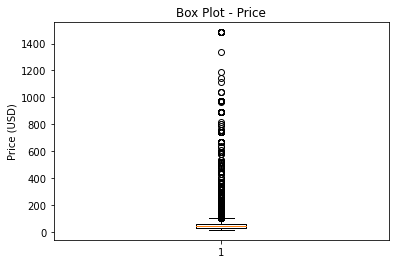

In [19]:
plt.boxplot(df['Price_USD'])
plt.ylabel('Price (USD)')
plt.title('Box Plot - Price')
plt.show()

In [4]:
Q1 = df['Price_USD'].quantile(0.25)
Q3 = df['Price_USD'].quantile(0.655)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Удаление строк с выбросами
df_filtered = df[(df['Price_USD'] >= lower_bound) & (df['Price_USD'] <= upper_bound)]

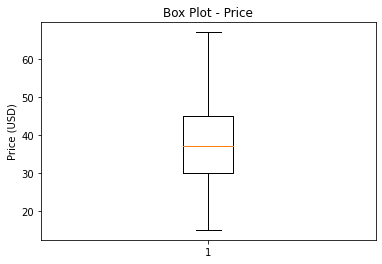

In [5]:
plt.boxplot(df_filtered['Price_USD'])
plt.ylabel('Price (USD)')
plt.title('Box Plot - Price')
plt.show()

In [62]:
print(df_filtered)

        Unnamed: 0   Age  Boobs  Height  Size  \
0                0  27.0    3.0   173.0  46.0   
1                1  27.0    3.0   168.0  46.0   
3                3  21.0    2.0   170.0  42.0   
4                4  35.0    4.0   180.0  46.0   
5                5  32.0    2.0   176.0  46.0   
...            ...   ...    ...     ...   ...   
214116      214116  21.0    2.0   165.0  42.0   
214117      214117  27.0    2.0   170.0  44.0   
214118      214118  25.0    2.0   168.0  44.0   
214122      214122  22.0    2.0   171.0  44.0   
214124      214124  28.0    2.0   160.0  44.0   

                                                 Metro  DateUpdate  Weight  \
0                      Алтуфьево, Медведково, Отрадное  07.09.2010    57.0   
1                                           Кунцевская  05.07.2010    65.0   
3                                        Тимирязевская  25.10.2006    60.0   
4                                        Проспект Мира  27.12.2010    70.0   
5             Белорус

In [6]:
df1 = df_filtered.iloc [:166091//2+1]
df2 = df_filtered.iloc [166091//2+1:]
print((np.size(df1)/9 +  np.size(df2)/9))

166091.0


In [7]:
price = np.array(df1[['Price_USD']])
price = price.ravel()
price_random = np.random.uniform(-5, 5, np.size(price))
price = price + price_random

Fitting 5 distributions: 100%|███████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,0.003757,913.807479,-1.404378e+06,0.067664,0.030382,4.960931e-67
norm,0.003967,916.869456,-1.399877e+06,0.070549,0.047134,9.127278e-161
cauchy,0.007194,946.958462,-1.350445e+06,0.115081,0.087041,0.000000e+00
uniform,0.015461,829.379742,-1.286906e+06,0.448363,0.219733,0.000000e+00
expon,0.023503,891.995314,-1.252125e+06,0.525941,0.292724,0.000000e+00


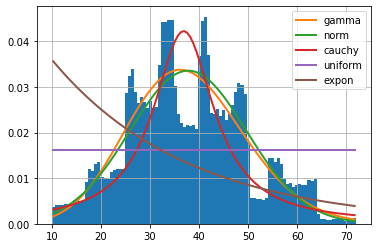

In [19]:
f = Fitter(price,
           distributions=["uniform", "expon", "norm", "gamma", "cauchy"])
f.fit()
f.summary()

In [20]:
f.get_best(method = 'sumsquare_error')

{'gamma': {'a': 55.067527047929914,
  'loc': -50.54612481978662,
  'scale': 1.603909574132334}}

Fitting 5 distributions: 100%|███████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]
weibull was not fitted. no parameters available


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.003766,914.134669,-1.404193e+06,0.067683,0.031568,2.478409e-72
beta,0.003850,914.420130,-1.402335e+06,0.070448,0.029236,4.226492e-62
laplace,0.007510,922.303401,-1.346874e+06,0.107020,0.069563,0.000000e+00
pareto,0.047285,976.185248,-1.194061e+06,1.091088,0.388240,0.000000e+00
weibull,inf,inf,inf,inf,NaN,NaN


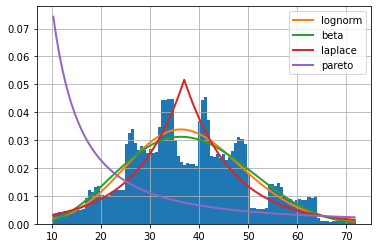

In [21]:
f = Fitter(price,
           distributions=["pareto", "laplace","lognorm", "weibull", "beta"])
f.fit()
f.summary()

In [22]:
f.get_best(method = 'sumsquare_error')

{'lognorm': {'s': 0.08484574117539119,
  'loc': -102.19664747352584,
  'scale': 139.47120692073577}}

Fitting 2 distributions: 100%|███████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,0.003757,913.807479,-1.404378e+06,0.067664,0.030382,4.960931e-67
lognorm,0.003766,914.134669,-1.404193e+06,0.067683,0.031568,2.478409e-72


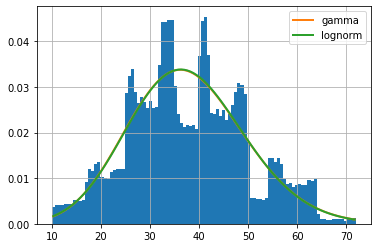

In [23]:
f = Fitter(price,
           distributions=["gamma", "lognorm"])
f.fit()
f.summary()

In [24]:
f.get_best(method = 'sumsquare_error')

{'gamma': {'a': 55.067527047929914,
  'loc': -50.54612481978662,
  'scale': 1.603909574132334}}

In [8]:
sample_beta_price = gamma.rvs(a = 58.518715615015616, loc=-53.514368475187126, scale=1.5593238632504738, size = np.size(df2))
price_2 = np.array(df2[['Price_USD']])
price_2 = price.ravel()
price_random_2 = np.random.uniform(-5, 5, np.size(price_2))
price_2 = price_2 + price_random_2
kstest(price_2, sample_beta_price)

KstestResult(statistic=0.015529791455721642, pvalue=4.353997757519142e-16)

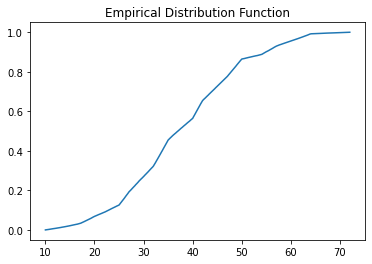

In [9]:
x = np.sort(price)
y = np.arange(1, np.size(x)+1) / np.size(x)
fig, ax = plt.subplots()
ax.plot(x, y, label='Empirical Distribution Function')
plt.title('Empirical Distribution Function')
plt.show()

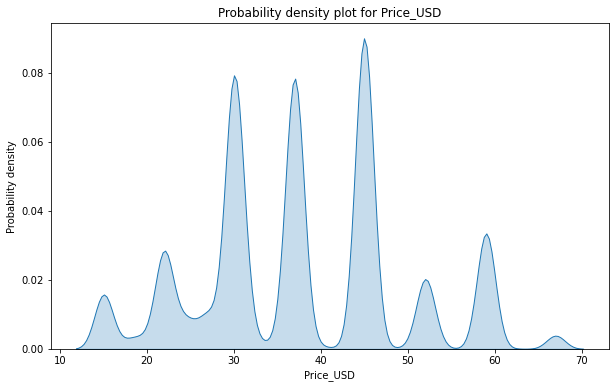

In [10]:
prices = df_filtered['Price_USD']

# График плотности вероятности
plt.figure(figsize=(10, 6))
sns.kdeplot(prices, shade=True)
plt.xlabel('Price_USD')
plt.ylabel('Probability density')
plt.title('Probability density plot for Price_USD')
plt.show()

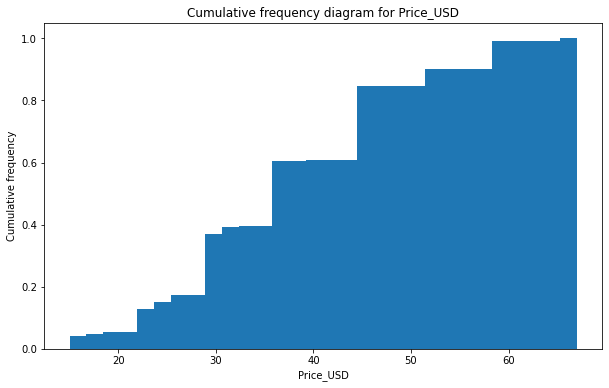

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(prices, cumulative=True, density=True, bins=30)
plt.xlabel('Price_USD')
plt.ylabel('Cumulative frequency')
plt.title('Cumulative frequency diagram for Price_USD')
plt.show()

C:\Users\5B34~1\AppData\Local\Temp/ipykernel_175456/2211880968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['DateUpdate'] = pd.to_datetime(df_filtered['DateUpdate'], format='%d.%m.%Y')
C:\Users\5B34~1\AppData\Local\Temp/ipykernel_175456/2211880968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Month'] = df_filtered['DateUpdate'].dt.month
C:\Users\5B34~1\AppData\Local\Temp/ipykernel_175456/2211880968.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

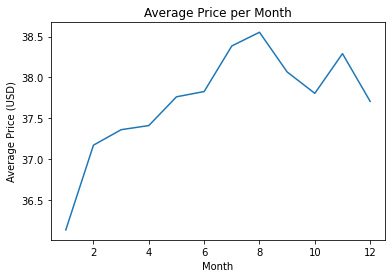

In [14]:
df_filtered['DateUpdate'] = pd.to_datetime(df_filtered['DateUpdate'], format='%d.%m.%Y')
df_filtered['Month'] = df_filtered['DateUpdate'].dt.month
df_filtered['Year'] = df_filtered['DateUpdate'].dt.year
df_filtered['Day'] = df_filtered['DateUpdate'].dt.day
monthly_avg_price = df_filtered.groupby('Month')['Price_USD'].mean()

plt.plot(monthly_avg_price.index, monthly_avg_price.values)
plt.xlabel('Month')
plt.ylabel('Average Price (USD)')
plt.title('Average Price per Month')
plt.show()

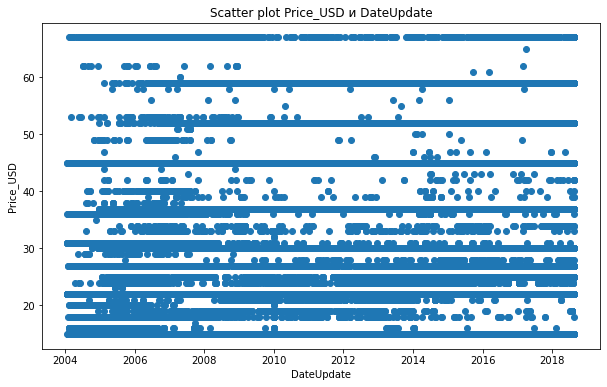

In [16]:
prices = df_filtered['Price_USD']
dates = df_filtered['DateUpdate']

# График рассеяния
plt.figure(figsize=(10, 6))
plt.scatter(dates, prices)
plt.xlabel('DateUpdate')
plt.ylabel('Price_USD')
plt.title('Scatter plot Price_USD и DateUpdate')
plt.show()

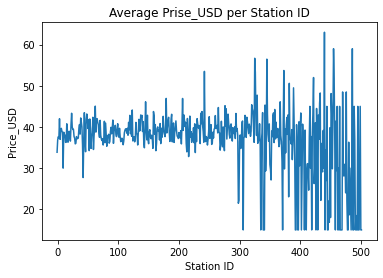

In [77]:
df_filtered['Station'] = df_filtered['Metro'].str.split(',')
df_filtered = df_filtered.explode('Station')
# Создание столбца "Station ID" с уникальными числовыми значениями для каждой станции метро
station_ids = df_filtered['Station'].explode().factorize()[0]
df_filtered['Station ID'] = station_ids

# Преобразование типа данных в столбце "Price_USD" в числовой формат
df_filtered['Price_USD'] = pd.to_numeric(df_filtered['Price_USD'], errors='coerce')

# Построение графика цены от номера станции метро
monthly_avg_price = df_filtered.groupby('Station ID')['Price_USD'].mean()
plt.plot(monthly_avg_price.index, monthly_avg_price.values)
plt.xlabel('Station ID')
plt.ylabel('Price_USD')
plt.title('Average Prise_USD per Station ID')
plt.show()

In [78]:
print(df_filtered)

        Unnamed: 0   Age  Boobs  Height  Size  \
0                0  27.0    3.0   173.0  46.0   
0                0  27.0    3.0   173.0  46.0   
0                0  27.0    3.0   173.0  46.0   
0                0  27.0    3.0   173.0  46.0   
0                0  27.0    3.0   173.0  46.0   
...            ...   ...    ...     ...   ...   
214124      214124  28.0    2.0   160.0  44.0   
214124      214124  28.0    2.0   160.0  44.0   
214124      214124  28.0    2.0   160.0  44.0   
214124      214124  28.0    2.0   160.0  44.0   
214124      214124  28.0    2.0   160.0  44.0   

                                    Metro DateUpdate  Weight  Price_USD  \
0         Алтуфьево, Медведково, Отрадное 2010-09-07    57.0       22.0   
0         Алтуфьево, Медведково, Отрадное 2010-09-07    57.0       22.0   
0         Алтуфьево, Медведково, Отрадное 2010-09-07    57.0       22.0   
0         Алтуфьево, Медведково, Отрадное 2010-09-07    57.0       22.0   
0         Алтуфьево, Медведково, Отр

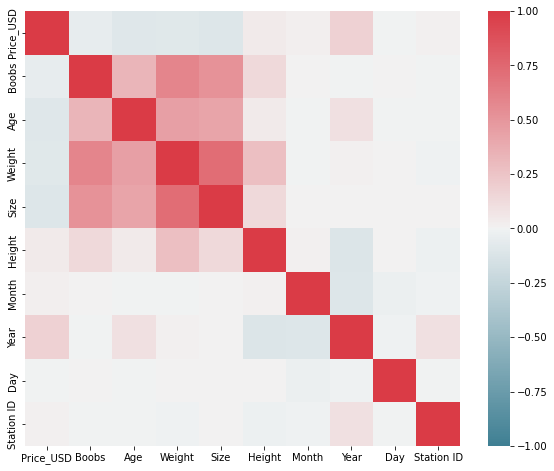

In [79]:
selected_columns = ['Price_USD', 'Boobs', 'Age', 'Weight', 'Size', 'Height', 'Month', 'Year', 'Day', 'Station ID']

# Создание подмножества данных с выбранными параметрами
data = df_filtered[selected_columns]

# Отображение статистической информации о данных
# print(data.describe())

# Создание фигуры для отображения матрицы корреляций
f, ax = plt.subplots(figsize=(10, 8))

# Вычисление матрицы корреляций
corr = data.corr()

# Создание тепловой карты с использованием seaborn
sns.heatmap(corr,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1.0, vmax=1.0,
            square=True, ax=ax)

# Отображение графика
plt.show()

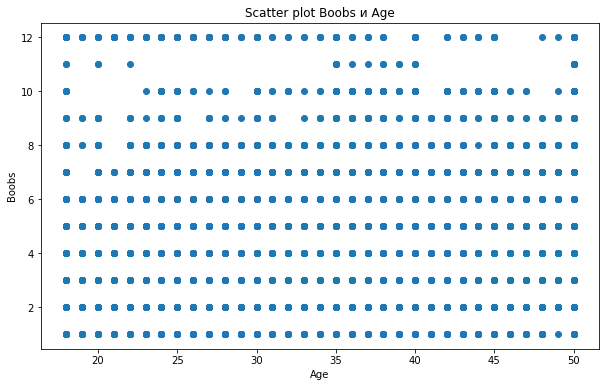

In [6]:
prices = df['Boobs']
dates = df['Age']

# График рассеяния
plt.figure(figsize=(10, 6))
plt.scatter(dates, prices)
plt.xlabel('Age')
plt.ylabel('Boobs')
plt.title('Scatter plot Boobs и Age')
plt.show()

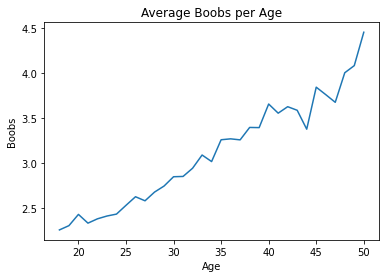

In [23]:
monthly_avg_price = df_filtered.groupby('Age')['Boobs'].mean()
plt.plot(monthly_avg_price.index, monthly_avg_price.values)
plt.xlabel('Age')
plt.ylabel('Boobs')
plt.title('Average Boobs per Age')
plt.show()

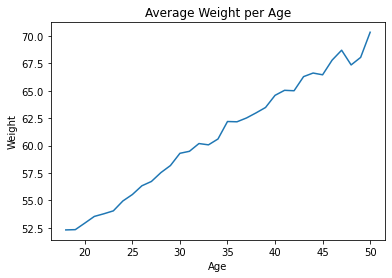

In [24]:
monthly_avg_price = df_filtered.groupby('Age')['Weight'].mean()
plt.plot(monthly_avg_price.index, monthly_avg_price.values)
plt.xlabel('Age')
plt.ylabel('Weight')
plt.title('Average Weight per Age')
plt.show()

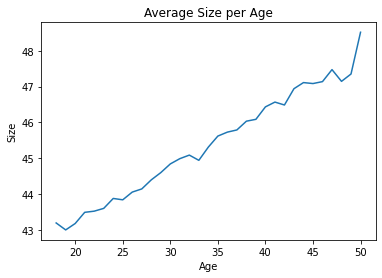

In [25]:
monthly_avg_price = df_filtered.groupby('Age')['Size'].mean()
plt.plot(monthly_avg_price.index, monthly_avg_price.values)
plt.xlabel('Age')
plt.ylabel('Size')
plt.title('Average Size per Age')
plt.show()

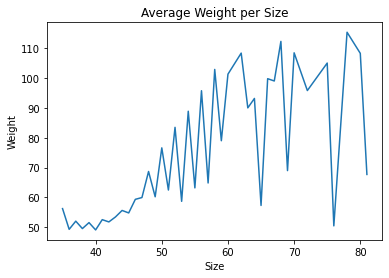

In [26]:
monthly_avg_price = df_filtered.groupby('Size')['Weight'].mean()
plt.plot(monthly_avg_price.index, monthly_avg_price.values)
plt.xlabel('Size')
plt.ylabel('Weight')
plt.title('Average Weight per Size')
plt.show()

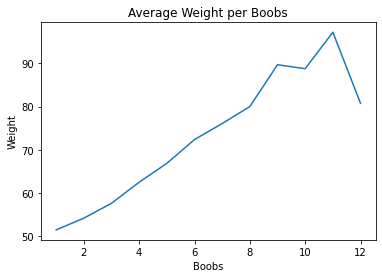

In [27]:
monthly_avg_price = df_filtered.groupby('Boobs')['Weight'].mean()
plt.plot(monthly_avg_price.index, monthly_avg_price.values)
plt.xlabel('Boobs')
plt.ylabel('Weight')
plt.title('Average Weight per Boobs')
plt.show()

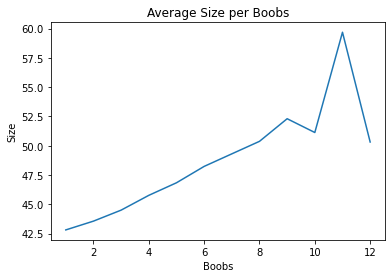

In [28]:
monthly_avg_price = df_filtered.groupby('Boobs')['Size'].mean()
plt.plot(monthly_avg_price.index, monthly_avg_price.values)
plt.xlabel('Boobs')
plt.ylabel('Size')
plt.title('Average Size per Boobs')
plt.show()

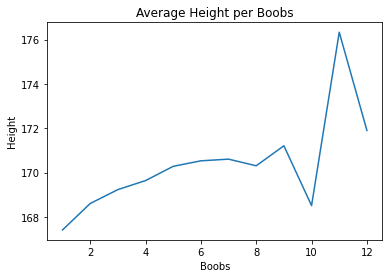

In [29]:
monthly_avg_price = df_filtered.groupby('Boobs')['Height'].mean()
plt.plot(monthly_avg_price.index, monthly_avg_price.values)
plt.xlabel('Boobs')
plt.ylabel('Height')
plt.title('Average Height per Boobs')
plt.show()

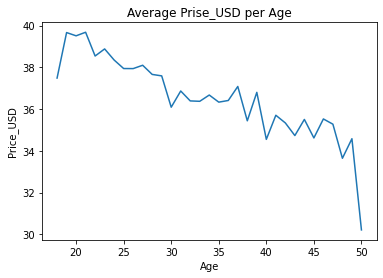

In [30]:
monthly_avg_price = df_filtered.groupby('Age')['Price_USD'].mean()
plt.plot(monthly_avg_price.index, monthly_avg_price.values)
plt.xlabel('Age')
plt.ylabel('Price_USD')
plt.title('Average Prise_USD per Age')
plt.show()

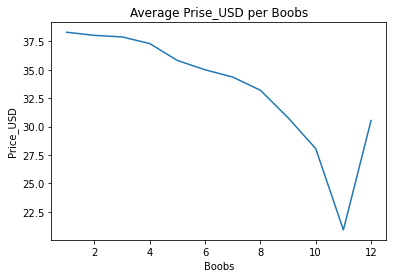

In [31]:
monthly_avg_price = df_filtered.groupby('Boobs')['Price_USD'].mean()
plt.plot(monthly_avg_price.index, monthly_avg_price.values)
plt.xlabel('Boobs')
plt.ylabel('Price_USD')
plt.title('Average Prise_USD per Boobs')
plt.show()

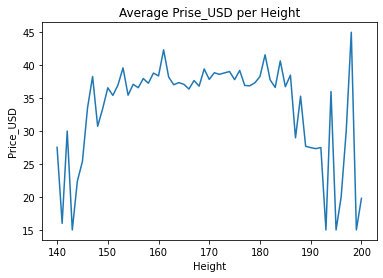

In [32]:
monthly_avg_price = df_filtered.groupby('Height')['Price_USD'].mean()
plt.plot(monthly_avg_price.index, monthly_avg_price.values)
plt.xlabel('Height')
plt.ylabel('Price_USD')
plt.title('Average Prise_USD per Height')
plt.show()

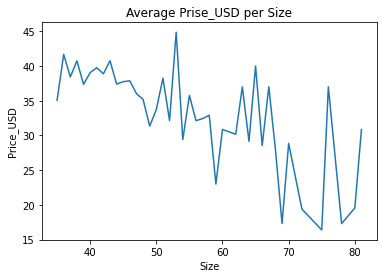

In [33]:
monthly_avg_price = df_filtered.groupby('Size')['Price_USD'].mean()
plt.plot(monthly_avg_price.index, monthly_avg_price.values)
plt.xlabel('Size')
plt.ylabel('Price_USD')
plt.title('Average Prise_USD per Size')
plt.show()

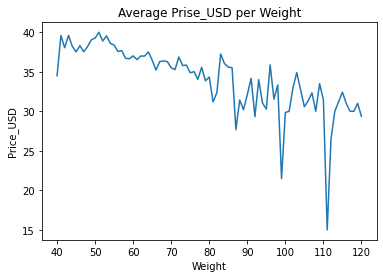

In [34]:
monthly_avg_price = df_filtered.groupby('Weight')['Price_USD'].mean()
plt.plot(monthly_avg_price.index, monthly_avg_price.values)
plt.xlabel('Weight')
plt.ylabel('Price_USD')
plt.title('Average Prise_USD per Weight')
plt.show()

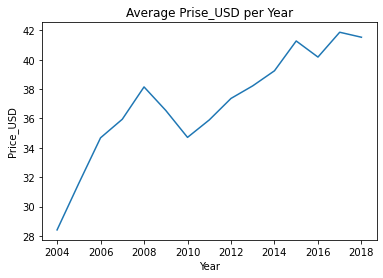

In [43]:
monthly_avg_price = df_filtered.groupby('Year')['Price_USD'].mean()
plt.plot(monthly_avg_price.index, monthly_avg_price.values)
plt.xlabel('Year')
plt.ylabel('Price_USD')
plt.title('Average Prise_USD per Year')
plt.show()

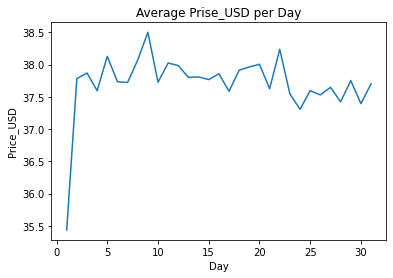

In [45]:
monthly_avg_price = df_filtered.groupby('Day')['Price_USD'].mean()
plt.plot(monthly_avg_price.index, monthly_avg_price.values)
plt.xlabel('Day')
plt.ylabel('Price_USD')
plt.title('Average Prise_USD per Day')
plt.show()

In [82]:
df1 = df_filtered.iloc [:2412182//2]
df2 = df_filtered.iloc [2412182//2:]
print((np.size(df1)/14, np.size(df2)/14))

(1206091.0, 1206091.0)


In [83]:
model = LinearRegression()
X = df1[['Boobs', 'Age', 'Weight', 'Size', 'Height', 'Month', 'Year', 'Day', 'Station ID']]
y = df1['Price_USD']

In [84]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [85]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [88]:
first = df2.iloc [:1206091]
price_square_meter = np.array(first[['Price_USD']])
new_data = first[['Boobs', 'Age', 'Weight', 'Size', 'Height', 'Month', 'Year', 'Day', 'Station ID']]

In [89]:
predictions = model.predict(new_data)
mape = mean_absolute_percentage_error(price_square_meter, predictions)
r_squared = model.score(X, y)
print(mape)
print(r_squared)

0.26607295717556967
0.061144091582336246


In [90]:
coef = model.coef_  # Коэффициенты
intercept = model.intercept_  # Свободный член
print("Коэффициенты:", coef)
print("Свободный член:", intercept)

Коэффициенты: [ 0.25572523 -0.14795412 -0.05913427 -0.22637496  0.19467104  0.09563639
  0.72709504  0.01440854 -0.0010174 ]
Свободный член: -1441.9140586455721


TypeError: '(slice(None, None, None), 0)' is an invalid key

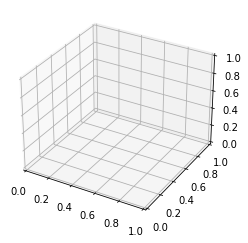

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], y, color='blue', label='Actual')
ax.scatter(X[:, 0], X[:, 1], y_pred, color='red', label='Predicted')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('y')
ax.set_title('Multivariate Linear Regression')
ax.legend()
plt.show()

In [57]:
age = np.array(df_filtered[['Age']])
age = age.ravel()
print(np.mean(age))

27.282959341565768


In [58]:
df_filtered_age = df_filtered[(df_filtered['Age'] >= 27) & (df_filtered['Age'] <= 28)]

In [59]:
boobs = np.array(df_filtered_age[['Boobs']])
boobs = boobs.ravel()
print(np.mean(boobs))

2.6230628431970713


In [60]:
df_filtered_boobs = df_filtered[(df_filtered['Age'] >= 2) & (df_filtered['Age'] <= 3)]

In [66]:
Height  = np.array(df_filtered_age[['Height']])
Height  = Height .ravel()
print(np.mean(Height ))

169.18200122025627


In [67]:
df_filtered_height = df_filtered[(df_filtered['Age'] >= 169) & (df_filtered['Age'] <= 170)]

In [68]:
Size = np.array(df_filtered_height[['Size']])
Size = Size.ravel()
print(np.mean(Size))

nan
